In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from random import shuffle
import random
import os

In [2]:
path = 'C:\\Users\\DEEP\\COVID-19-X-Ray-Classification-master\\'

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [3]:
directories = ['Training_data_gval']
categories = []
    
files = os.listdir(path + directories[0])

for img in files:

    fileName = img.split('.')[0]
    
    if 'Normal' in fileName: categories.append(0)
    elif 'COVID' in fileName: categories.append(1)
    else: categories.append(2)


df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [4]:
df

,filename,category
0,COVID-1.png,1
1,COVID-10.png,1
2,COVID-100.png,1
3,COVID-101.png,1
4,COVID-102.png,1
...,...,...
895,Viral Pneumonia-95.png,2
896,Viral Pneumonia-96.png,2
897,Viral Pneumonia-97.png,2
898,Viral Pneumonia-98.png,2


<AxesSubplot:>

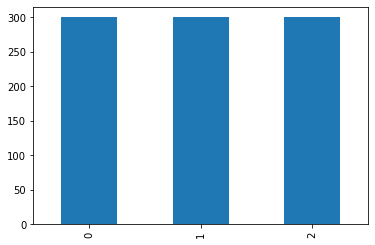

In [5]:
'''
0 Represents Normal 
1 Represents COVID-19
2 Represents Viral Pneumonia 
'''
df["category"] = df["category"].astype("category")
df['category'].value_counts().plot.bar()

Viral Pneumonia-15.png


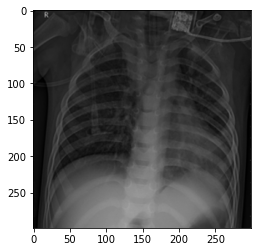

In [6]:
sample = random.choice(os.listdir(path + directories[0]))
image = load_img(path + '\\Training_data_gval\\' + sample)

print(sample)
plt.imshow(image)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax', name='predictions')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [10]:
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID', 2: 'Viral Pneumonia'}) 

<AxesSubplot:>

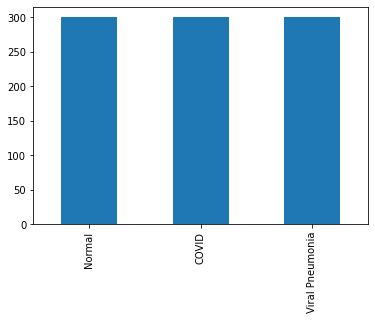

In [11]:
df['category'].value_counts().plot.bar()

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df

,filename,category
0,Viral Pneumonia-278.png,Viral Pneumonia
1,Viral Pneumonia-279.png,Viral Pneumonia
2,COVID-49.png,COVID
3,COVID-68.png,COVID
4,Normal-282.png,Normal
...,...,...
895,COVID-266.png,COVID
896,Normal-194.png,Normal
897,Normal-291.png,Normal
898,Normal-261.png,Normal


In [13]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

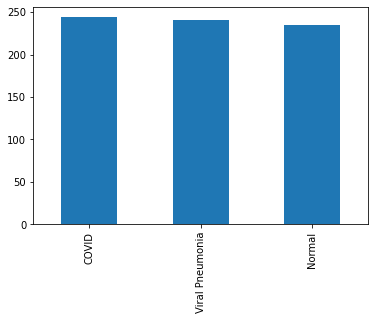

In [14]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

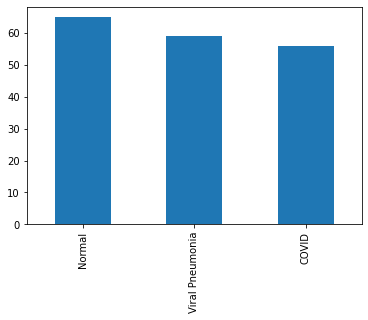

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 5

In [17]:
train_datagen = ImageDataGenerator (
    
    #rotation_range = 15,
    rescale = 1./255,
    
   # shear_range = 0.1,
    # zoom_range = 0.2,
    
    #horizontal_flip = True,
    #width_shift_range = 0.1,
    #height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe (
    
    train_df, 
    path + '\\Training_data_gval', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 720 validated image filenames belonging to 3 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe (
    
    validate_df, 
    path + '\\Training_data_gval', 
    x_col ='filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 180 validated image filenames belonging to 3 classes.


In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe (
    
    example_df, 
    path + '\\Training_data_gval', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


                  filename         category
0  Viral Pneumonia-130.png  Viral Pneumonia


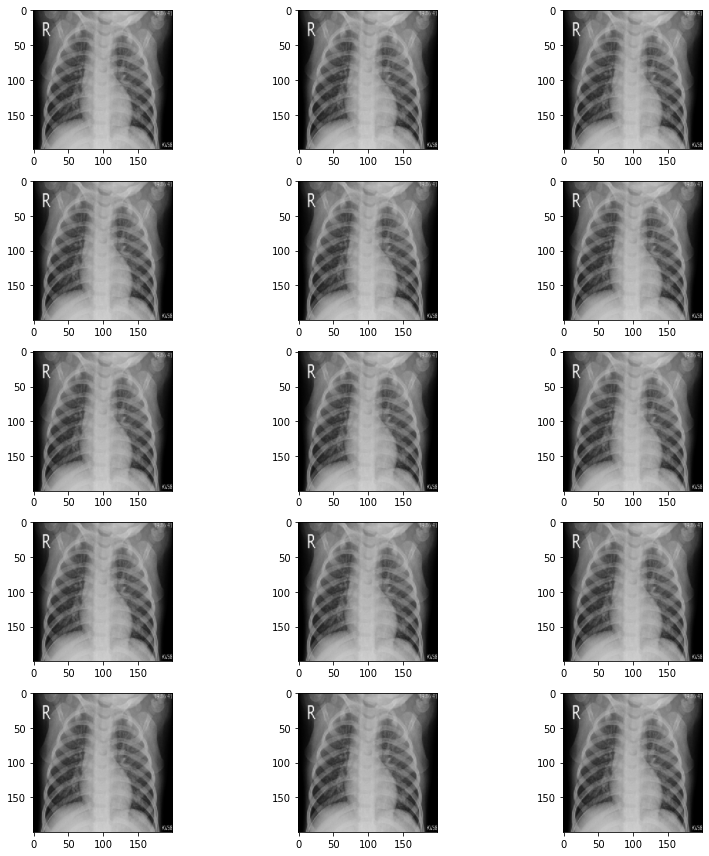

In [20]:
print(example_df)

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    
    plt.subplot(5, 3, i+1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

In [21]:
epochs = 25

history = model.fit_generator (
    
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

C:\Users\DEEP\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
144/144 [==============================] - 27s 175ms/step - loss: 1.0688 - accuracy: 0.6375 - val_loss: 3.1810 - val_accuracy: 0.3500
Epoch 2/25
144/144 [==============================] - 26s 183ms/step - loss: 0.8063 - accuracy: 0.7167 - val_loss: 3.3276 - val_accuracy: 0.3667
Epoch 3/25
144/144 [==============================] - 28s 193ms/step - loss: 0.7290 - accuracy: 0.7611 - val_loss: 2.3078 - val_accuracy: 0.5389
Epoch 4/25
144/144 [==============================] - 27s 188ms/step - loss: 0.6338 - accuracy: 0.7806 - val_loss: 0.5914 - val_accuracy: 0.8167
Epoch 5/25
144/144 [==============================] - 22s 155ms/step - loss: 0.5324 - accuracy: 0.8014 - val_loss: 3.4456 - val_accuracy: 0.5444
Epoch 6/25
144/144 [==============================] - 23s 159ms/step - loss: 0.5791 - accuracy: 0.7861 - val_loss: 0.9342 - val_accuracy: 0.7167

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/25
144/144 [=============================

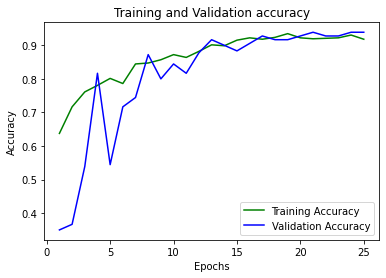

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  25 + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

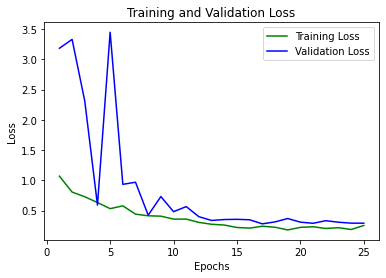

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  25 + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
test_filenames = os.listdir(path + 'Test_data')

test_df = pd.DataFrame({
    'filename': test_filenames
})

nb_samples = test_df.shape[0]
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename
0,Normal-1831.png
1,COVID-1733.png
2,Normal-1853.png
3,Normal-1887.png
4,Normal-1896.png
...,...
596,COVID-1752.png
597,Viral Pneumonia-862.png
598,Normal-1927.png
599,Viral Pneumonia-801.png


In [25]:
test_df

,filename
0,Normal-1831.png
1,COVID-1733.png
2,Normal-1853.png
3,Normal-1887.png
4,Normal-1896.png
...,...
596,COVID-1752.png
597,Viral Pneumonia-862.png
598,Normal-1927.png
599,Viral Pneumonia-801.png


In [26]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    
    test_df, 
    path + '\\Test_data', 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 601 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\DEEP\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df

,filename,category
0,Normal-1831.png,Normal
1,COVID-1733.png,Viral Pneumonia
2,Normal-1853.png,COVID
3,Normal-1887.png,COVID
4,Normal-1896.png,Normal
...,...,...
596,COVID-1752.png,COVID
597,Viral Pneumonia-862.png,Viral Pneumonia
598,Normal-1927.png,COVID
599,Viral Pneumonia-801.png,COVID


In [30]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'COVID': 1, 'Viral Pneumonia': 2})

<AxesSubplot:>

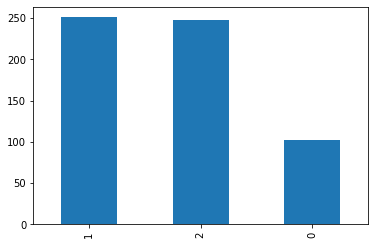

In [31]:
test_df['category'].value_counts().plot.bar()

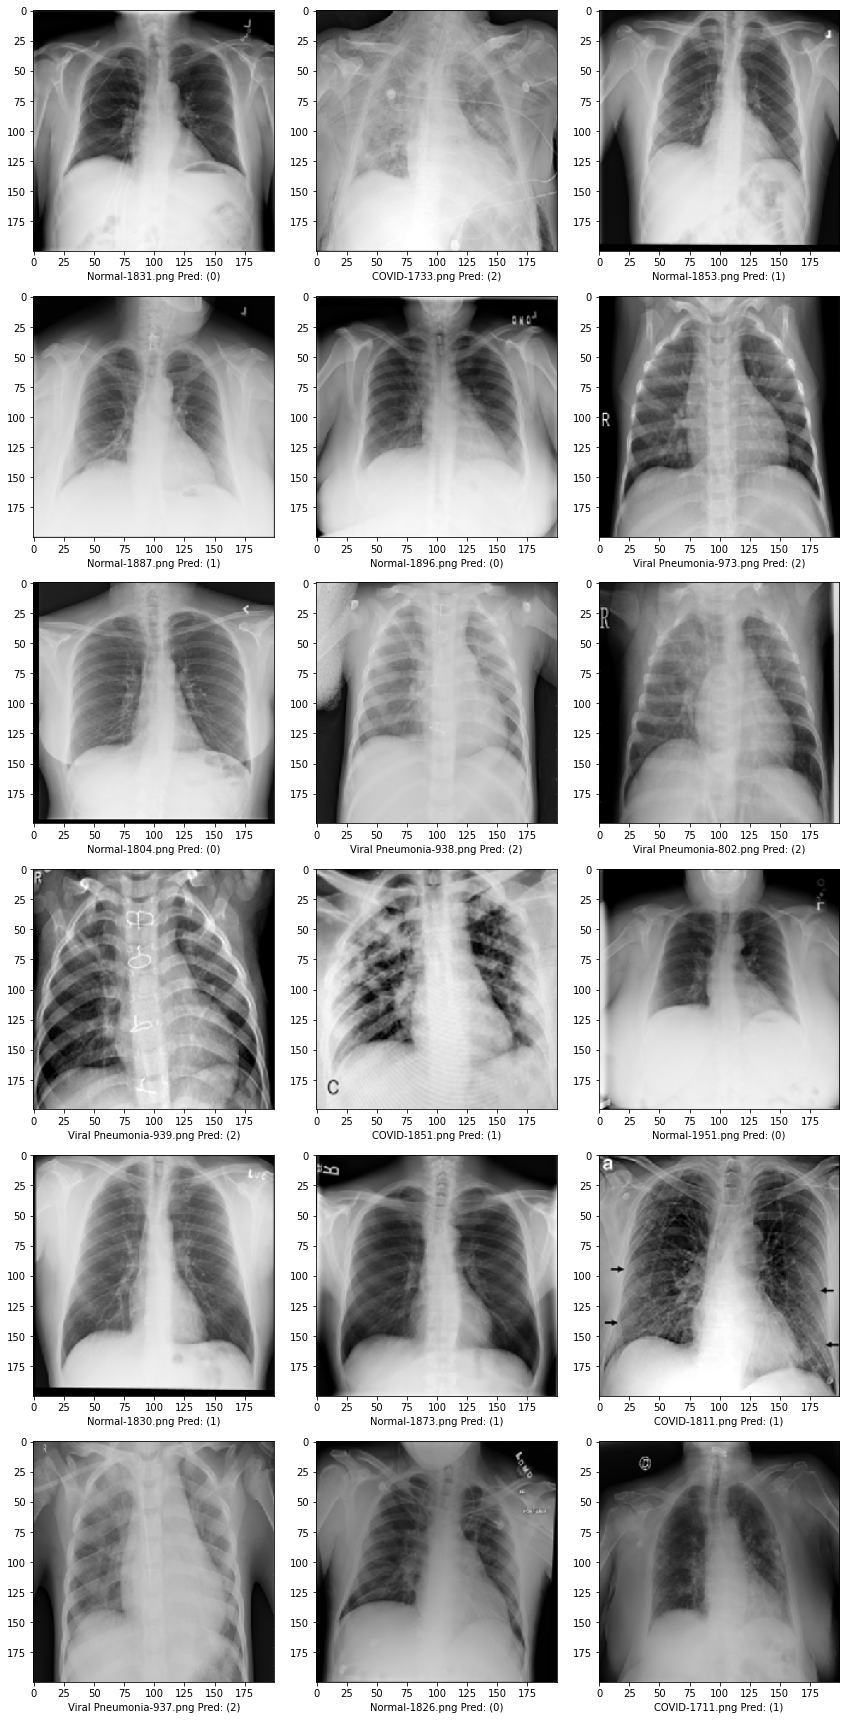

In [32]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img(path + 'Test_data\\' + filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

In [33]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img(path + 'Test_data\\' + filename, target_size=IMAGE_SIZE)
    
    if 'Normal' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in filename:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [34]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 73.88%
Correct Predictions: 444 Total Predictions: 601

Normal Predictions: 95 Accuracy 47.26%
COVID-19 Predictions: 155 Accuracy 77.50%
Viral Pneumonia Predictions: 194 Accuracy 97.00%
